# Part 00: Notebook overview ..

In [1]:

#  This Notebook is part of a set that demonstrate GNN using a movie dataset.
#  About this Notebook,
#
#  .  There was a Kaggle GNN challenge circa 2019 detailed here,
#        https://www.kaggle.com/c/movie-genre-classification/data
#
#     That data is locked down, but a similarly themed dataset also on 
#     Kaggle is here,
#        https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
#
#     The above is the data set in use here.
#
#     In this first NoteBook, basically we mung input data, and create
#     graphs.
#
#
#  .  1 GB, plus or minus. Most of that volume comes from reviews. The
#     movies run 30-40 MB, and the cast and crew about 190 MB.
#
#     The data is CSV, with embedded arrays of JSON.
#     To remove dependencies on GS/S3 hosted data, this program expects this
#     data to be local to the container hosting this Jupyter Notebook.
#
#     Since we host all of our assets on GitHub, and GitHub has a 25 MB file
#     size limit, the total data set is now split across multiple files.
#     You do not need to host data on GitHub. You will need the CSV data
#     files that we read to be local, and under a folder titled,
#        ./02_Files
#
#  .  The existing schema for just Movies is listed here,
#  
#        10_movies_metadata.csv
#        -----------------------------------------
#           adult                      ..   False
#           belongs_to_collection      ..
#           budget                     ..   2700000
#           genres                     ..   "[{'id': 35, 'name': 'Comedy'}]"
#           homepage                   ..   http://www.animalhouse.com/
#           id                         ..   8469
#           imdb_id                    ..   tt0077975
#           original_language          ..   en
#           original_title             ..   Animal House
#           overview                   ..   "At a 1962 College, Dean Vernon Wormer is determined to expel
#                                            the entire Delta Tau Chi Fraternity, but those troublemakers
#                                            have other plans for him."
#           popularity                 ..   7.525382
#           poster_path                ..   /AuJkgAh7zAGsm7Oo3CGyDtYvzg0.jpg
#           production_companies       ..   "[{'name': 'Universal Pictures', 'id': 33}, {'name': 'Oregon Film Factory',
#                                               'id': 13298}, {'name': 'Stage III Productions', 'id': 13300}]"
#           production_countries       ..   "[{'iso_3166_1': 'US', 'name': 'United States of America'}]"
#           release_date               ..   1978-07-27
#           revenue                    ..   141000000
#           runtime                    ..   109.0
#           spoken_languages           ..   "[{'iso_639_1': 'en', 'name': 'English'}]"
#           status                     ..   Released
#           tagline                    ..   It was the Deltas against the rules... the rules lost!
#           title                      ..   Animal House
#           video                      ..   False
#           vote_average               ..   7.0
#           vote_count                 ..   420
#
#     From the above, we load the following into a DataFrame of Movie nodes,
#
#           id                         ..   8469
#           id_asint                   ..   8469
#           title                      ..   Animal House
#           genres                     ..   "[{'id': 35, 'name': 'Comedy'}]"
#           overview                   ..   "At a 1962 College, Dean Vernon Wormer is determined to expel
#                                            the entire Delta Tau Chi Fraternity, but those troublemakers
#                                            have other plans for him."
#           tagline                    ..   It was the Deltas against the rules... the rules lost!
#
#           popularity                 ..   7.525382
#           production_companies       ..   "[{'name': 'Universal Pictures', 'id': 33}, {'name': 'Oregon Film Factory',
#                                               'id': 13298}, {'name': 'Stage III Productions', 'id': 13300}]"
#           release_date               ..   1978-07-27
#           revenue                    ..   141000000
#           runtime                    ..   109.0
#           spoken_languages           ..   "[{'iso_639_1': 'en', 'name': 'English'}]"
#           vote_average               ..   7.0
#           vote_count                 ..   420
#
#      Notice the following from above,
#
#         ..  genres is an array of JSON, with each genre being unique identified via a numeric.
#             We will take the first genre and put it into a property on each node titled, primary_genre.
#         ..  We will leave all remaining JSON untouched, stored as strings.


#  .  The existing schema is for Keywords is listed here,
#
#        11_keywords.csv
#        -----------------------------------------
#           id                         ..   8469
#           keywords                   ..   "[{'id': 572, 'name': 'sex'}, {'id': 2483, 'name': 'nudity'},
#                                             {'id': 3616, 'name': 'college'}, {'id': 157632, 'name': 'fraternity'},
#                                             {'id': 158507, 'name': 'gross out comedy'}, {'id': 160450, 'name': 'dean'},
#                                             {'id': 171400, 'name': 'fraternity house'}, {'id': 208983, 'name': 'probation'},
#                                             {'id': 208992, 'name': '1960s'}, {'id': 209506, 'name': 'college freshman'},
#                                             {'id': 236316, 'name': 'anarchic comedy'}]"
#
#      From the above, the following is offered,
#   
#         ..  id  joins with  movie.id
#         ..  keywords.id  already enumerates keywords associated with the movies for us.
#             Super handy.


#  .  We also have data for,
# 
#        ..  12_Credits  (split into; Cast, Crew)
#        ..  14|15_Ratings
#        ..  16|17_(External) Links
#
#     And will likely add these at a later date.


#  Below we continue by loading the raw data, and performing some validations on
#  statements made, assumptions, and similar.



#  Part 01: Load just Movies into a DataFrame, first look, first data corrections, drop unwanted columns

Enter:  

   - (Nothing)
   - (Data files local on disk)
   
Exit:

   - Boolean :: MY_DEBUG
   - DF :: df_movies
   

In [2]:

#  Setting display options, and a flag for outputting more information
#

import pandas as pd
   #
pd.set_option("display.width", 480)

#  Sets horizontal scroll for wide outputs
#
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from tabulate import tabulate


MY_DEBUG = True
# MY_DEBUG = False
   #
print("--")


--


In [3]:

import dask.dataframe as dd
import numpy as np
   #
#  import pandas as pd                                        #  Already above

import json

print("--")


--


In [4]:

#  WRITE: Load DataFrame with raw input data associated with Movies
#

l_InputFiles  = [
   "./02_Files/40_Movies_01.txt",
   "./02_Files/41_Movies_02.txt",
]

#  Import as type string, and handle errors later.
#
df_data1 = dd.read_csv(
   l_InputFiles,
   delimiter  = ",",
   skiprows   = 1,                                            #  Skip the first line of each file, since it's the column headers
   dtype      = {
      "adult"                     : np.dtype(str),
      "belongs_to_collection"     : np.dtype(str),
      "budget"                    : np.dtype(str),
      "genres"                    : np.dtype(str),
      "homepage"                  : np.dtype(str),
      "id"                        : np.dtype(str),
      "imdb_id"                   : np.dtype(str),
      "original_language"         : np.dtype(str),
      "original_title"            : np.dtype(str),
      "overview"                  : np.dtype(str),
      "popularity"                : np.dtype(str),
      "poster_path"               : np.dtype(str),
      "production_companies"      : np.dtype(str),
      "production_countries"      : np.dtype(str),
      "release_date"              : np.dtype(str),
      "revenue"                   : np.dtype(str),
      "runtime"                   : np.dtype(str),
      "spoken_languages"          : np.dtype(str),
      "status"                    : np.dtype(str),
      "tagline"                   : np.dtype(str),
      "title"                     : np.dtype(str),
      "video"                     : np.dtype(str),
      "vote_average"              : np.dtype(str),
      "vote_count"                : np.dtype(str),
      },
   names      = [
      "adult", "belongs_to_collection", "budget", "genres", "homepage", "id", "imdb_id",
      "original_language", "original_title", "overview", "popularity", "poster_path",
      "production_companies", "production_countries", "release_date", "revenue", "runtime",
      "spoken_languages", "status", "tagline", "title", "video", "vote_average", "vote_count",
      ]
   )   

df_data1.compute()

print("--")


--


In [5]:

#  READ-ONLY: Initial look at the data, sanity check-
#

if (MY_DEBUG):
   print("Count of Movies: %d" % (len(df_data1.index)))
      #
   print(tabulate(df_data1.head(2), headers='keys', tablefmt='psql'))

   l_cntr = 0
      #
   print("")
   print("ID         Title                              Tagline")
   print("========   ================================   ===========================================")
      #
   for l_each in df_data1.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 10):
         print("%8s   %-32s   %s" % (l_each.id, l_each.title, l_each.tagline))
   
print("--")

#  Sample output,
#
#     Count of Movies: 45466
#     +----+---------+----------------------------------------------   -------------------------------------------------------+----------+---------------------------------------------
#     |    | adult   | belongs_to_collection                                                                                  |   budget | genres                          
#     |----+---------+-------------------------------------------   ----------------------------------------------------------+----------+-------------------------------------------------
#     |  0 | False   | {'id': 10194, 'name': 'Toy Story Collectij   pg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'} | 30000000 | [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id'
#     |  1 | False   | nan                                                                                                    | 65000000 | [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'na
#     +----+---------+----------------------------------------   -------------------------------------------------------------+----------+---------------------------------------
#     
#     ID         Title                              Tagline
#     ========   ================================   ===========================================
#          862   Toy Story                          nan
#         8844   Jumanji                            Roll the dice and unleash the excitement!
#        15602   Grumpier Old Men                   Still Yelling. Still Fighting. Still Ready for Love.
#        31357   Waiting to Exhale                  Friends are the people who let you be yourself... and never let you forget it.
#        11862   Father of the Bride Part II        Just When His World Is Back To Normal... He's In For The Surprise Of His Life!
#          949   Heat                               A Los Angeles Crime Saga
#        11860   Sabrina                            You are cordially invited to the most surprising merger of the year.
#        45325   Tom and Huck                       The Original Bad Boys.
#         9091   Sudden Death                       Terror goes into overtime.



Count of Movies: 45466
+----+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+---------------------------------------------------------------------------------------------------+--------------------------------------+------+-----------+---------------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-----------------

In [6]:

#  READ-ONLY: Check df_data.id, see if it is a valid integer
#

#  A couple of ways to do this. Because we're making this function more
#  re-usable, it adds some code below.
#
    
def f_check_int(i_arg1, i_arg2):
    
   l_cntr = 0
   l_fail = 0
 
   #  This approach uses named, then ordinal reference (ordinal: by position/number).
   #
   # for l_each in i_arg1[[i_arg2]].itertuples():
   #    l_cntr += 1
   #       #
   #    try:
   #       int(l_each[1])
   #    except:
   #       print("Column not an integer value: %s" % (l_each[1]) )
   #       l_fail+= 1
        
   #  This approach uses a dictionary, and is the one we prefer.
   #
   for l_each in i_arg1.itertuples():
      l_cntr += 1
         #
      try:
        
         # l_each_dict = l_each._asdict()    
         # l_each_id   = l_each_dict.get(i_arg2)
        
         l_each_id  = l_each._asdict().get(i_arg2)
            #
         int(l_each_id)
        
      except:
         print("Column not an integer value: %s" % (l_each_id) )
         l_fail+= 1
        
   return(l_cntr, l_fail)
           
       
if (MY_DEBUG):
   l_cntr, l_fail = f_check_int(df_data1, "id")
      #
   print("")
   print("Number of rows: %d   Number of bad rows: %d" % (l_cntr, l_fail) )  #

print("--")
    
    
#  Sample output,
#
#     Column not an integer value: 1997-08-20
#     Column not an integer value: 2012-09-29
#     Column not an integer value: 2014-01-01
#
#     Number of rows: 45466   Number of bad rows: 3


Column not an integer value: 1997-08-20
Column not an integer value: 2012-09-29
Column not an integer value: 2014-01-01

Number of rows: 45466   Number of bad rows: 3
--


In [7]:

#  WRITE: Create a new column with just valid integer movie ids
#

#  This one line construct works, is safe, other. But .. .. it overwrites
#  the existing id column. There is no means currently, using this construct,
#  to save the output to a newly created column.
#
# df_data = df_data[df_data.id.str.isnumeric()]


def f_cast_int(i_arg1):
   try:
      l_return = int(i_arg1) 
   except:
      l_return = -1
   return l_return


df_data1["id_asint"] = df_data1.id.map(lambda x: f_cast_int(x) )


if(MY_DEBUG):
   print(tabulate(df_data1[["id", "id_asint", "title", "tagline"]].head(4), headers='keys', tablefmt='psql'))
   print("")
      #
   l_cntr = 0
   l_fail = 0
      #
   for l_each in df_data1.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 3):
         print(type(l_each.id_asint))
      if (l_each.id_asint == -1):
         l_fail += 1
            #
   print("")
   print("Number of rows with a -1 value for id_asint: %d" % (l_fail))
            
print("--")


#  Sample output,
#
#     +----+-------+------------+-------------------+--------------------------------------------------------------------------------+
#     |    |    id |   id_asint | title             | tagline                                                                        |
#     |----+-------+------------+-------------------+--------------------------------------------------------------------------------|
#     |  0 |   862 |        862 | Toy Story         | nan                                                                            |
#     |  1 |  8844 |       8844 | Jumanji           | Roll the dice and unleash the excitement!                                      |
#     |  2 | 15602 |      15602 | Grumpier Old Men  | Still Yelling. Still Fighting. Still Ready for Love.                           |
#     |  3 | 31357 |      31357 | Waiting to Exhale | Friends are the people who let you be yourself... and never let you forget it. |
#     +----+-------+------------+-------------------+--------------------------------------------------------------------------------+


+----+-------+------------+-------------------+--------------------------------------------------------------------------------+
|    |    id |   id_asint | title             | tagline                                                                        |
|----+-------+------------+-------------------+--------------------------------------------------------------------------------|
|  0 |   862 |        862 | Toy Story         | nan                                                                            |
|  1 |  8844 |       8844 | Jumanji           | Roll the dice and unleash the excitement!                                      |
|  2 | 15602 |      15602 | Grumpier Old Men  | Still Yelling. Still Fighting. Still Ready for Love.                           |
|  3 | 31357 |      31357 | Waiting to Exhale | Friends are the people who let you be yourself... and never let you forget it. |
+----+-------+------------+-------------------+--------------------------------------------------

In [8]:

#  WRITE: Above, we potentially created a number of movies with the
#  same id: -1
#  These were movies with a non-integer "id". This count was reported
#  above.
#
#  Filter these rows out.
#

print(len(df_data1))

df_data2 = df_data1[df_data1.id_asint != -1]
   #
del df_data1

print(len(df_data2))

#  Sample output,
#
#     45466
#     45463


45466
45463


In [9]:

#  WRITE: Later we will (classify, node label predict) on; title, tagline,
#  overview.
#  As such, we want to be certain these are present (effectively, not null).
#

def f_check_title_tagline_overview(i_arg1):
   l_cntr1 = 0
   l_cntr2 = 0
   l_cntr3 = 0
      #
   for l_each in i_arg1.itertuples():
      #
      #  This construct should work for missing columns also
      #
      if not (isinstance(l_each.title   , str)):
         l_cntr1 += 1
      if not (isinstance(l_each.tagline , str)):
         l_cntr2 += 1
      if not (isinstance(l_each.overview, str)):
         l_cntr3 += 1
            #
   return (l_cntr1, l_cntr2, l_cntr3)


if (MY_DEBUG):
   l_cntr1, l_cntr2, l_cntr3 = f_check_title_tagline_overview(df_data2)
      # 
   print("Num of bad titles: %-6d   Bad taglines: %-6d   Bad overviews: %-6d" % (l_cntr1, l_cntr2, l_cntr3))


#  Fixing missing or incorrect data
#
df_data3 = df_data2.assign(
   title    = lambda x: x.title   .fillna("Unknown").astype(str),
   tagline  = lambda x: x.tagline .fillna("Unknown").astype(str),
   overview = lambda x: x.overview.fillna("Unknown").astype(str),
   )
      #
del df_data2


if (MY_DEBUG):
   l_cntr1, l_cntr2, l_cntr3 = f_check_title_tagline_overview(df_data3)
      # 
   print("Num of bad titles: %-6d   Bad taglines: %-6d   Bad overviews: %-6d" % (l_cntr1, l_cntr2, l_cntr3))


print("--")

#  Sample output
#
#     Num of bad titles: 3        Bad taglines: 25051    Bad overviews: 954   
#     Num of bad titles: 0        Bad taglines: 0        Bad overviews: 0  


Num of bad titles: 3        Bad taglines: 25051    Bad overviews: 954   
Num of bad titles: 0        Bad taglines: 0        Bad overviews: 0     
--


In [10]:

#  WRITE: Drop unwanted columns (keep wanted columns)
#

try:
   df_movies = df_data3[["id", "id_asint", "title", "overview", "tagline", "budget",
      "genres", "popularity", "production_companies", "release_date", "revenue",
      "runtime", "vote_average", "vote_count", ]]
   df_movies.compute()
   del df_data3
except:
   pass

if (MY_DEBUG):
   print(tabulate(df_movies.head(2), headers='keys', tablefmt='psql'))

print("--")

#  Sample data,
#
#     +----+------+------------+-----------+---------------------------------------------------------------------------------------------------------
#     |    |   id |   id_asint | title     | overview                                                                                       
#     |----+------+------------+-----------+---------------------------------------------------------------------------------------------------------------
#     |  0 |  862 |        862 | Toy Story | Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto th
#     |  1 | 8844 |       8844 | Jumanji   | When siblings Judy and Peter discover an enchanted board game that opens the door to a magic
#     +----+------+------------+-----------+-----------------------------------------------------------------------------------------------------


+----+------+------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------+----------+---------------------------------------------------------------------------------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-----------+----------------+--------------+
|    |   id |   id_asint | title     | overview                                                                                                                                           

#  Part 02: Check just Genres, a column in Movies, save primary genres with id

We are actually done with Movies proper at this point, and have only genres data, which is embedded in Movies, to process.

Enter:  

   - DF :: df_movies
   - Boolean :: MY_DEBUG
   
Exit:

   - DF :: df_movies
   - Boolean :: MY_DEBUG


In [11]:

#  READ-ONLY: Check column type of genres; Eg., how should we process this data
#

if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_movies.itertuples():
      l_cntr += 1
      if (l_cntr < 3):
         print(type(l_each.genres))
         print(     l_each.genres )
        
print("--")

#  Sample output,
#
#     <class 'str'>
#     [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
#     <class 'str'>
#     [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]


<class 'str'>
[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
<class 'str'>
[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]
--


In [12]:

#  WRITE:
#
#  . Save the original 'genres' string as JSON, 'genres_json'.
#  . Save the first 'genres.name' as 'genres_primary'.
#  . Save the first 'genres.id'   as 'genres_primary_id'.
#
#  .  Why 'primary' ?
#        Many movies are listed as having many genres. Since we act
#        to demonstrate node prediction, we want fewer/easier node
#        (types).
#
#        Given more data, it might be better to just combine these
#        multiple genres listing into one (hybrid) genre per movie.


#  Effectively, here, we are checking if the string is valid JSON.
#  The proper quotes get munged each time we save, and you will see
#  we effectively run this mung/cast each time when decoding this
#  string.
#
def f_genres_json(i_arg1):
   try:
      l_str1 = str(i_arg1)                                                  #  Needed this, was getting odd  json.loads()  errors otherwise
      l_str2 = l_str1.replace("'", "\"")
      l_str3 = json.loads(l_str2)
      l_return = l_str3
   except:
      l_return = json.loads('[{"id": -1, "name": "Unknown"}]')              #  This is a genres_json.id, and genres_json.name
   return l_return
      #
df_movies["genres_json"      ] = df_movies.genres.map     (lambda x: f_genres_json(x)       )


if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_movies.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 3):
         print(str(type(l_each.genres_json)) + "   " + str(type(l_each.genres_json[0])) + "   " + str(l_each.genres_json))
        
        
#  This block can get deleted-
#     Effectively this block is replaced by a better block below.
#     Really just keeping this block for teaching.
#
#  def f_genres_primary(i_arg1):
#     try:
#        l_return = i_arg1[0]["name"]
#     except:
#        l_return = "Unknown"
#     return l_return
#        #
#  def f_genres_primary_id(i_arg1):
#     try:
#        l_return = i_arg1[0]["id"]
#     except:
#        l_return = -1
#     return l_return
#     #
#  df_movies["genres_primary"   ] = df_movies.genres_json.map(lambda x: f_genres_primary   (x) )
#  df_movies["genres_primary_id"] = df_movies.genres_json.map(lambda x: f_genres_primary_id(x) )


def f_primary(i_arg1, i_col):
   try:
      l_return = i_arg1[0][i_col]
   except:
      if (i_col == "id"):
         l_return = -1
      else:
         l_return = "Unknown"
   return l_return
      #
df_movies["genres_primary"   ] = df_movies.genres_json.map(lambda x: f_primary(x, "name") )
df_movies["genres_primary_id"] = df_movies.genres_json.map(lambda x: f_primary(x, "id"  ) )
   #
df_movies = df_movies.assign(LABEL=lambda x: "Movies")
        
        
if (MY_DEBUG):
   l_cntr = 0
   print("")
      #
   for l_each in df_movies.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 3):
         print(str(type(l_each.genres_primary)) + "   " + l_each.genres_primary + "   " + str(type(l_each.genres_primary_id)) + "   " + str(l_each.genres_primary_id))
        
      
print("--")


#  Sample output,
#
#     <class 'list'>   <class 'dict'>   [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
#     <class 'list'>   <class 'dict'>   [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]
#     
#     <class 'str'>   Animation   <class 'int'>   16
#     <class 'str'>   Adventure   <class 'int'>   12


<class 'list'>   <class 'dict'>   [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
<class 'list'>   <class 'dict'>   [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]

<class 'str'>   Animation   <class 'int'>   16
<class 'str'>   Adventure   <class 'int'>   12
--


In [13]:

#  READ-ONLY:  (we do create stuff here, but only to report, and discard in the same cell)
#   
#  Analysis on just genres- How many unique values do we have ?
#
#     .  Copy just  Movies.genres_json  into a new DataFrame. 
#     .  Extract all  'Movies.genres_json.name'  from the JSON string into list.
#     .  Pivot this list of genres names into separate rows.
#     .  Count the unique genres names.


df_genres1 = df_movies[["genres_json"]]


#  Convert the genres_json array of dictionaries into an array of just genres.names
#
def f_genres_arr(i_arg1):
   l_arr  = []
      #
   try:
      for l_each in i_arg1:
         l_name = l_each["name"]
         l_arr += [l_name]
      l_return = l_arr
   except:
      l_return = [ "Unknown" ]
   return l_return
      #
df_genres1["genres_names"] = df_genres1.genres_json.map(lambda x: f_genres_arr(x), meta=("genres_json", "object"))


#  Count the above with a group by, and sort
#
df_genres2 = df_genres1.explode("genres_names")
   #
df_genres3 = df_genres2.groupby("genres_names")["genres_names"].count().compute().reset_index(name="count").sort_values(by="count", ascending=False)
    

      ########################################
        
        
#  Output for review
#
if (MY_DEBUG):
   l_cntr = 0
   print("All   Genre entries for all movies ..")
   print("-------------------------------")
      #
   for l_each in df_genres3.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 50):
         print("Genre name: %-48s  %d" % (l_each.genres_names, l_each.count))
           
   print("Total: %d" % (len(df_genres3.index)))
   print("")


      ########################################


#  See how the above differs from df_data2.genres_primary
#
df_genres4 = df_movies.groupby("genres_primary")["genres_primary"].count().compute().reset_index(name="count").sort_values(by="count", ascending=False)
    

#  Output for review
#
if (MY_DEBUG):
   l_cntr = 0
   print("First Genre entry   for all movies ..")
   print("-------------------------------")
      #
   for l_each in df_genres4.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 50):
         print("Genre name: %-48s  %d" % (l_each.genres_primary, l_each.count))
    
   print("Total: %d" % (len(df_genres4.index)))
   print("")
    
    
      ########################################
        
        
del df_genres1
del df_genres2
del df_genres3
# del df_genres4                                                    #  Save df_genres4, we may use it in the next cell
   #
print("--")


#  Sample output,
#
#     All   Genre entries for all movies ..
#     -------------------------------
#     Genre name: Drama                                             20265
#     Genre name: Comedy                                            13182
#     Genre name: Thriller                                          7624
#     Genre name: Romance                                           6735
#     Genre name: Action                                            6596
#     Genre name: Horror                                            4673
#     Genre name: Crime                                             4307
#     Genre name: Documentary                                       3932
#     Genre name: Adventure                                         3496
#     Genre name: Science Fiction                                   3049
#     Genre name: Family                                            2770
#     Genre name: Mystery                                           2467
#     Genre name: Fantasy                                           2313
#     Genre name: Animation                                         1935
#     Genre name: Foreign                                           1622
#     Genre name: Music                                             1598
#     Genre name: History                                           1398
#     Genre name: War                                               1323
#     Genre name: Western                                           1042
#     Genre name: TV Movie                                          767
#     Total: 20
#     
#     First Genre entry   for all movies ..
#     -------------------------------
#     Genre name: Drama                                             11966
#     Genre name: Comedy                                            8820
#     Genre name: Action                                            4489
#     Genre name: Documentary                                       3415
#     Genre name: Horror                                            2619
#     Genre name: Unknown                                           2442                #  We created this value from missing data.
#     Genre name: Crime                                             1685
#     Genre name: Thriller                                          1665
#     Genre name: Adventure                                         1514
#     Genre name: Romance                                           1191
#     Genre name: Animation                                         1124
#     Genre name: Fantasy                                           704
#     Genre name: Science Fiction                                   647
#     Genre name: Mystery                                           554
#     Genre name: Family                                            524
#     Genre name: Music                                             487
#     Genre name: Western                                           451
#     Genre name: TV Movie                                          390
#     Genre name: War                                               379
#     Genre name: History                                           279
#     Genre name: Foreign                                           118
#     Total: 21



#  Before some of the data corrections/validations we made above, there 
#  were more Genres Names.
#
#  Samples of those,
#
#     Genre name: Odyssey Media                                     1
#     Genre name: Pulser Productions                                1
#     Genre name: Rogue State                                       1
#     Genre name: Vision View Entertainment                         1
#     Genre name: Mardock Scramble Production Committee             1
#     Genre name: Telescene Film Group Productions                  1
#     Genre name: Sentai Filmworks                                  1
#     Genre name: GoHands                                           1
#     Genre name: Carousel Productions                              1
#     Genre name: BROSTA TV                                         1
#     Genre name: Aniplex                                           1
#     Genre name: The Cartel                                        1



All   Genre entries for all movies ..
-------------------------------
Genre name: Drama                                             20265
Genre name: Comedy                                            13182
Genre name: Thriller                                          7624
Genre name: Romance                                           6735
Genre name: Action                                            6596
Genre name: Horror                                            4673
Genre name: Crime                                             4307
Genre name: Documentary                                       3932
Genre name: Adventure                                         3496
Genre name: Science Fiction                                   3049
Genre name: Family                                            2770
Genre name: Mystery                                           2467
Genre name: Fantasy                                           2313
Genre name: Animation                                    

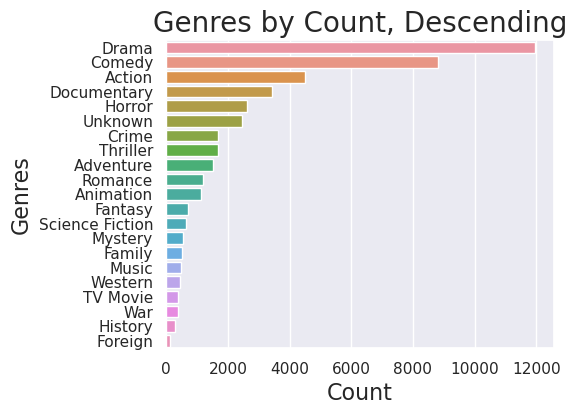

--


In [14]:

#  Graph visually, use one of the already included/installed libraries-
#
#     See, https://seaborn.pydata.org/generated/seaborn.barplot.html
#          https://seaborn.pydata.org/examples/index.html
#

import seaborn as sns
import matplotlib.pyplot as plt


if (MY_DEBUG):
   sns.set(rc = {'figure.figsize':(5,4)})

   sns.barplot(x = "count", y = "genres_primary", data=df_genres4)
   
   plt.title("Genres by Count, Descending", fontsize = 20)
   plt.xlabel("Count",  size = 16)
   plt.ylabel("Genres", size = 16)
   
   plt.show()
    
    
del df_genres4
   #
print("--")



<div> 
<img src="./01_Images/20-BarChart-1.png" alt="Drawing" style="width: 800px;"/>
</div>


#  Part 00: Checkpoint our current state

Enter:  

   - DF :: df_movies
   - Boolean :: MY_DEBUG
   
Exit:

   - DF :: df_movies
   - Boolean :: MY_DEBUG
   

In [15]:

#  We have a DataFrame titled,  df_movies  with the following features,
#
#     id                         ..   8469
#     id_asint                   ..   8469,              an integer
#     title                      ..   Animal House
#     overview                   ..   "At a 1962 College, Dean Vernon Wormer is determined to expel
#                                      the entire Delta Tau Chi Fraternity, but those troublemakers
#                                      have other plans for him."
#     tagline                    ..   It was the Deltas against the rules... the rules lost!
#     budget                     ..   2700000
#     genres                     ..   "[{'id': 35, 'name': 'Comedy'}]"
#     popularity                 ..   7.525382
#     production_companies       ..   "[{'name': 'Universal Pictures', 'id': 33}, {'name': 'Oregon Film Factory',
#                                         'id': 13298}, {'name': 'Stage III Productions', 'id': 13300}]"
#     release_date               ..   1978-07-27
#     revenue                    ..   141000000
#     runtime                    ..   109.0
#     vote_average               ..   7.0
#     vote_count                 ..   420
#
#     genres_json                ..   (same as above, case as JSON/dictionary)
#     genres_primary             ..   Just the first genres.name, a string
#     genres_primary_id          ..   Just the first genres.id, an integer
    
    
#  Currently, one use case for GNN requires a bi-partitite graph. We have additional data
#  sets for,
#
#        11_keywords.csv
#        -----------------------------------------
#           id                         ..   8469
#           keywords                   ..   "[{'id': 572, 'name': 'sex'}, {'id': 2483, 'name': 'nudity'},
#                                             {'id': 3616, 'name': 'college'}, {'id': 157632, 'name': 'fraternity'},
#                                             {'id': 158507, 'name': 'gross out comedy'}, {'id': 160450, 'name': 'dean'},
#                                             {'id': 171400, 'name': 'fraternity house'}, {'id': 208983, 'name': 'probation'},
#                                             {'id': 208992, 'name': '1960s'}, {'id': 209506, 'name': 'college freshman'},
#                                             {'id': 236316, 'name': 'anarchic comedy'}]"
#
#      From the above, the following is offered,
#   
#         ..  id  joins with movie.id
#         ..  keywords.id  already enumerates keywords associated with the movies for us.
#             Super handy.
#
#  .  We also have data for,
# 
#        ..  12_Credits  (split into; Cast, Crew)
#        ..  14|15_Ratings
#        ..  16|17_(External) Links


#  From here, we proceed with just  keywords
#


# Part 03: Work on Keywords, which also gives us the Edge between Movies and Keywords

Enter:  

   - DF :: df_movies
   - Boolean :: MY_DEBUG
   
Exit:

   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_described_by
   - Boolean :: MY_DEBUG
   

In [16]:

#  WRITE: Load DataFrame with raw input data. This time we are looking
#  at keywords.
#

l_InputFiles  = [
   "./02_Files/50_Keywords_00.txt",
]

df_data1 = dd.read_csv(
   l_InputFiles,
   delimiter  = ",",
   skiprows   = 1,                                            #  Skip the first line of each file, since it's the column headers
   dtype      = {
      "id"                        : np.dtype(str),            #  This relates to movie.id
      "keywords"                  : np.dtype(str),            #  In the source CSV, this column was titled 'values', a bad idea.
      },                                                      #     (We see below, this is actually a JSON array; each entry itself with an id and a keyword name.)
   names      = [
      "id", "keywords"
      ]
   )   

df_data1.compute()

print("--")


--


In [17]:

#  READ-ONLY: Initial look at the data, sanity check-
#

if(MY_DEBUG):
   print("Number of keyword data lines: %d" % len(df_data1.index))
      #
   print(tabulate(df_data1.head(2), headers='keys', tablefmt='psql'))

   l_cntr = 0
   l_fail = 0
      #
   for l_each in df_data1.itertuples():
      l_cntr += 1
      try:
         int(l_each.id)
      except:
         print("Keyword with a non-integer keyword.id value: %s" % (l_each.id))
         l_fail += 1
    
   print("")
      #
   print("Number of total keyword data lines: %d  Number with numeric id: %d   Number with a non-numeric id: %d" % (l_cntr, (l_cntr - l_fail), l_fail ))


print("--")


#  Sample output,
#
#     Number of keyword data lines: 46419
#     +----+------+----------------------------------------------------------------------------------------------------------------------------------------------
#     |    |   id | keywords                                                                                                                      
#     |----+------+------------------------------------------------------------------------------------------------------------------------------------
#     |  0 |  862 | [{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 97
#     |  1 | 8844 | [{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'name': "based on children's book"}, {'id': 33467, 'name': 'n
#     +----+------+--------------------------------------------------------------------------------------------------------------------------------
#     
#     Number of total keyword data lines: 46419  Number with numeric id: 46419   Number with a non-numeric id: 0


Number of keyword data lines: 46419
+----+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   id | keywords                                                                                                                                                                                                                                                                                                                   |
|----+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:

#  WRITE: We always import data as type string, as we prefer to do data
#  correction at our own control, (versus whatever casting failures might
#  occur when importing as integer, or other more restrictive data types).
#
#     (It looked like the keywords.id field was entirely made of integers,
#     but, lets also count when we convert this field.)
#
#  keywords.id was brought in as type string. Create keywords.id_asint
#

df_data2 = df_data1.assign(
   id_asint = lambda x: x.id.fillna(-1).astype(int),
   )
      #
del df_data1


if(MY_DEBUG):
   print(tabulate(df_data2[["id", "id_asint", "keywords"]].head(4), headers='keys', tablefmt='psql'))
   print("")
      #
   l_cntr = 0
   l_fail = 0
      #
   for l_each in df_data2.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 3):
         print(type(l_each.id_asint))
      if (l_each.id_asint == -1):
         l_fail += 1
            #
   print("")
   print("Number of rows with a -1 value for id_asint: %d" % (l_fail))


#  Sample output
#
#     +----+-------+------------+----------------------------------------------------------------------------------------------
#     |    |    id |   id_asint | keywords                                                                             
#     |----+-------+------------+------------------------------------------------------------------------------------------------------
#     |  0 |   862 |        862 | [{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy
#     |  1 |  8844 |       8844 | [{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'na
#     |  2 | 15602 |      15602 | [{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 
#     |  3 | 31357 |      31357 | [{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id':
#     +----+-------+------------+--------------------------------------------------------------------------------------
#     
#     <class 'int'>
#     <class 'int'>
#     
#     Number of rows with a -1 value for id_asint: 0


+----+-------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |    id |   id_asint | keywords                                                                                                                                                                                                                                                                                                                   |
|----+-------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:

#  READ-ONLY: Now we have lists of keys for movie.id in two dataframes;
#  df_movies from above, and this, df_data
#  
#  How well do the two lists match up ?  (Do the join pairs align well ?)


if (MY_DEBUG):
    
   #  Think of this a a standard SQL left outer join-
   #
   df_data3 = df_data2.copy()
      #
   df_intersect1 = df_movies.merge(df_data3.drop_duplicates(), on=["id_asint","id_asint"], how="left", indicator=True)
      #
   l_in_movies   = 0
   l_in_both_m   = 0
      #
   for l_each in df_intersect1.itertuples():
      if (l_each._21 == "both"):
         l_in_both_m   += 1
      else:
         print("Id of movie not found in keywords list: %-10s   %-10s   Title: %s" % (l_each.id_x, l_each._21, l_each.title))
         l_in_movies   += 1
            #
   del df_data3


   print("")
            

   df_movies2 = df_movies[["id_asint"]]
      #
   df_intersect2 = df_data2.merge(df_movies2.drop_duplicates(), on=["id_asint","id_asint"], how="left", indicator=True)
      #
   l_in_keywords = 0
   l_in_both_k   = 0
      #
   for l_each in df_intersect2.itertuples():
      if (l_each._4 == "both"):
         l_in_both_k   += 1
      else:
         print("Id of keyword not found in movies list: %-10s   %-10s   %s" % (l_each.id_asint, l_each._4, str(l_each.keywords)))
         l_in_keywords += 1
            #
   del df_movies2
            
            
   print("")
      #
   print("Number of movies:                                     %10d" % (len(df_movies)))
   print("Number of keyword records:                            %10d" % (len(df_data2 )))
   print("-------------------------------------------------------------------------")
   print("Count where same id in both lists (parent: movie):    %10d" % (l_in_both_m))
   print("Count where same id in both lists (parent: keywords): %10d" % (l_in_both_k))
   print("Count where movie.id not in keywords.id:              %10d" % (l_in_movies))
   print("Count where keyword.id not in movie.id:               %10d" % (l_in_keywords))

   del df_intersect1
   del df_intersect2
      #
   print("")


print("--")

#  Sample output,
#
#     Id of movie not found in keywords list: 401840       left_only    Title: School's out
#     
#     Number of movies:                                          45463
#     Number of keyword records:                                 46419
#     -------------------------------------------------------------------------
#     Count where same id in both lists (parent: movie):         45462
#     Count where same id in both lists (parent: keywords):      46419
#     Count where movie.id not in keywords.id:                       1
#     Count where keyword.id not in movie.id: 

#  Above,
#
#     .  There is one movie id with no corresponding keyword record.
#        We are okay with that.
#        In graph parlance, we will have two sets of nodes (Movies and 
#        Keywords), and one of the Movies will have no relationship to
#        Keywords. That does happen.


Id of movie not found in keywords list: 401840       left_only    Title: School's out


Number of movies:                                          45463
Number of keyword records:                                 46419
-------------------------------------------------------------------------
Count where same id in both lists (parent: movie):         45462
Count where same id in both lists (parent: keywords):      46419
Count where movie.id not in keywords.id:                       1
Count where keyword.id not in movie.id:                        0

--


In [20]:

#  WRITE: A number of the keywords string (array)'s are empty. 
#  Let's get sense of those, and add them to, 
#     (df_data.keywords_length)
#

def f_length(i_arg1):
   try:
      l_str1 = str(i_arg1) 
      l_str2 = l_str1.replace("'", "\"")
      l_str3 = json.loads(l_str2)
      l_return = len(l_str3)
   except:
      l_return = -1
   return l_return

df_data2["keywords_length"] = df_data2.keywords.map(lambda x: f_length(x))


if (MY_DEBUG):
   df_data3 = df_data2.groupby("keywords_length")["keywords_length"].count().compute().reset_index(name="count").sort_values(by="keywords_length", ascending=True)
      #
   print("Number of keywords == -1,   Means we couldn't parse the JSON string.")
   print("Number of keywords ==  0,   Means there really were zero values in valid JSON.")
   print("--------------------------------------------")
      #
   l_cntr = 0
   l_nbad = 0
      #
   for l_each in df_data3.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 10):
         print("Number of keywords:   %-6d   How many records of this count: %d" % (l_each.keywords_length, l_each.count))
      if (l_each.keywords_length < 1):
         l_nbad += l_each.count

   print("")
   print("Total records: %d   Number of bad records: %d   Percentage: %d %%" % ( len(df_data2), l_nbad, (l_nbad / len(df_data2) * 100 )) )
      #
   del df_data3
   
    
print("--")

#  Sample output,
#
#     Number of keywords == -1,   Means we couldn't parse the JSON string.
#     Number of keywords ==  0,   Means there really were zero values in valid JSON.
#     --------------------------------------------
#     Number of keywords:   -1       How many records of this count: 631
#     Number of keywords:   0        How many records of this count: 14795
#     Number of keywords:   1        How many records of this count: 6610
#     Number of keywords:   2        How many records of this count: 4779
#     Number of keywords:   3        How many records of this count: 4244
#     Number of keywords:   4        How many records of this count: 3255
#     Number of keywords:   5        How many records of this count: 2802
#     Number of keywords:   6        How many records of this count: 1914
#     Number of keywords:   7        How many records of this count: 1456
#
#     Total records: 46419   Number of bad records: 15426   Percentage: 33 %

#  Comment; With 33% of our records not having keywords, that will limit
#  the effeciveness of adding keywords to any ML/predicive-analytics we perform.


Number of keywords == -1,   Means we couldn't parse the JSON string.
Number of keywords ==  0,   Means there really were zero values in valid JSON.
--------------------------------------------
Number of keywords:   -1       How many records of this count: 631
Number of keywords:   0        How many records of this count: 14795
Number of keywords:   1        How many records of this count: 6610
Number of keywords:   2        How many records of this count: 4779
Number of keywords:   3        How many records of this count: 4244
Number of keywords:   4        How many records of this count: 3255
Number of keywords:   5        How many records of this count: 2802
Number of keywords:   6        How many records of this count: 1914
Number of keywords:   7        How many records of this count: 1456

Total records: 46419   Number of bad records: 15426   Percentage: 33 %
--


In [21]:

#  WRITE: Change/repair those missing/other keyword records above-
#
#     Strangely, map() works with an "if", map_partitions() does not.


def f_repair(i_arg1):

   #  This form of "if" block,
   #
   #     if (i_arg1.keywords_length < 1):
   #        return "[{'id': -1, 'name': 'Unknown'}]"
   #     else:
   #        return i_arg1.keywords
   #     return l_return
   #
   #  Throws this error,
   #     >> ValueError('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().')
   #
   #  So we use this form of "if" below,
    
   l_return = np.where(i_arg1.keywords_length < 1 , "[{'id': -1, 'name': 'Unknown'}]", i_arg1.keywords)
                       
   return l_return
    

df_data2["keywords_str"] = df_data2.map_partitions(f_repair)


if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_data2.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 10):
         print(l_each.keywords_str)
    

print("--")


#  Sample output,
#
#     [{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friends
#     [{'id': -1, 'name': 'Unknown'}]
#     [{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': 'duringcreditsstin
#     [{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id': 14768, 'name': 'single 
#     [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'confidence'}, {'id': 4995, 'name': '
#     [{'id': 642, 'name': 'robbery'}, {'id': 703, 'name': 'detective'}, {'id': 974, 'name': 'bank'}, {'id': 1523, 'name': 'obses
#     [{'id': 90, 'name': 'paris'}, {'id': 380, 'name': 'brother brother relationship'}, {'id': 2072, 'name': 'chauff
#     [{'id': -1, 'name': 'Unknown'}]
#     [{'id': 949, 'name': 'terrorist'}, {'id': 1562, 'name': 'hostage'}, {'id': 1653, 'name': 'explosive'}, {'id': 193533, 'na


[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]
[{'id': -1, 'name': 'Unknown'}]
[{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': 'duringcreditsstinger'}, {'id': 208510, 'name': 'old men'}]
[{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id': 14768, 'name': 'single mother'}, {'id': 15160, 'name': 'divorce'}, {'id': 33455, 'name': 'chick flick'}]
[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'confidence'}, {'id': 4995, 'name': 'aging'}, {'id': 5600, 'name': 'daughter'}, {'id': 10707, 'name': 'mother daughter relationship'}, {'id': 13149, 'name': 'pregnancy'}, {'id': 33358, 'name': 'contracep

In [22]:

#  WRITE: This cell is a direct copy of a cell two above. Here though, we run the
#  routines on our corrected keywords_str, where before it raw keywords.
#

def f_length(i_arg1):
   try:
      l_str1 = str(i_arg1) 
      l_str2 = l_str1.replace("'", "\"")
      l_str3 = json.loads(l_str2)
      l_return = len(l_str3)
   except:
      l_return = -1
   return l_return

df_data2["keywords_length"] = df_data2.keywords_str.map(lambda x: f_length(x))


if (MY_DEBUG):
   df_data3 = df_data2.groupby("keywords_length")["keywords_length"].count().compute().reset_index(name="count").sort_values(by="keywords_length", ascending=True)
      #
   print("Number of keywords == -1,   Means we couldn't parse the JSON string.")
   print("Number of keywords ==  0,   Means there really were zero values in valid JSON.")
   print("--------------------------------------------")
      #
   l_cntr = 0
   l_nbad = 0
      #
   for l_each in df_data3.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 10):
         print("Number of keywords:   %-6d   How many records of this count: %d" % (l_each.keywords_length, l_each.count))
      if (l_each.keywords_length < 1):
         l_nbad += l_each.count

   print("")
   print("Total records: %d   Number of bad records: %d   Percentage: %d %%" % ( len(df_data2), l_nbad, (l_nbad / len(df_data2) * 100 )) )
      #
   del df_data3
   
    
print("--")


#  Sample output from before,
#
#     Number of keywords:   -1       How many records of this count: 631
#     Number of keywords:   0        How many records of this count: 14795
#     Number of keywords:   1        How many records of this count: 6610
#     Number of keywords:   2        How many records of this count: 4779
#     Number of keywords:   3        How many records of this count: 4244
#     Number of keywords:   4        How many records of this count: 3255
#     Number of keywords:   5        How many records of this count: 2802
#     Number of keywords:   6        How many records of this count: 1914
#     Number of keywords:   7        How many records of this count: 1456
#
#     Total records: 46419   Number of bad records: 15426   Percentage: 33 %

#  Sample output now,
#
#     Number of keywords == -1,   Means we couldn't parse the JSON string.
#     Number of keywords ==  0,   Means there really were zero values in valid JSON.
#     --------------------------------------------
#     Number of keywords:   1        How many records of this count: 22036
#     Number of keywords:   2        How many records of this count: 4779
#     Number of keywords:   3        How many records of this count: 4244
#     Number of keywords:   4        How many records of this count: 3255
#     Number of keywords:   5        How many records of this count: 2802
#     Number of keywords:   6        How many records of this count: 1914
#     Number of keywords:   7        How many records of this count: 1456
#     Number of keywords:   8        How many records of this count: 1016
#     Number of keywords:   9        How many records of this count: 832
#     
#     Total records: 46419   Number of bad records: 0   Percentage: 0 %

#  Comment;  the data is cleaner, not more informative. Effectively we
#  updated all of the (bad) data to equal, [{"id": -1, "name": "Unknown"}]



Number of keywords == -1,   Means we couldn't parse the JSON string.
Number of keywords ==  0,   Means there really were zero values in valid JSON.
--------------------------------------------
Number of keywords:   1        How many records of this count: 22036
Number of keywords:   2        How many records of this count: 4779
Number of keywords:   3        How many records of this count: 4244
Number of keywords:   4        How many records of this count: 3255
Number of keywords:   5        How many records of this count: 2802
Number of keywords:   6        How many records of this count: 1914
Number of keywords:   7        How many records of this count: 1456
Number of keywords:   8        How many records of this count: 1016
Number of keywords:   9        How many records of this count: 832

Total records: 46419   Number of bad records: 0   Percentage: 0 %
--


In [23]:

#  WRITE:  keywords_str is currently a string, covert to a dictionary,
#  so that we may pivot (explode) later

def f_keywords_json(i_arg1):
   try:
      l_str1 = str(i_arg1)                                                  #  Needed this, was getting odd  json.loads()  errors otherwise
      l_str2 = l_str1.replace("'", "\"")
      l_str3 = json.loads(l_str2)
      l_return = l_str3
   except:
      l_return = json.loads('[{"id": -1, "name": "Unknown"}]')
   return l_return

df_data2["keywords_json"] = df_data2.keywords_str.map(lambda x: f_keywords_json(x))
    

if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_data2.itertuples():
      l_cntr +=1
         #
      if (l_cntr < 3):
         print(l_each.id, l_each.keywords_json)
         print(type(l_each.keywords_json))

print("--")

#  Sample output,
#
#     862 [{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]
#     <class 'list'>
#     8844 [{'id': -1, 'name': 'Unknown'}]
#     <class 'list'>


862 [{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]
<class 'list'>
8844 [{'id': -1, 'name': 'Unknown'}]
<class 'list'>
--


In [24]:

#  WRITE: Build a new DataFrame with the unique Keywords. 
#
#  We'll use this to count, but also this can be our list of nodes for the graph
#  with Label, Keywords.


#  Here is our pivot, and drop duplicates
#
df_data3 = df_data2[["id", "keywords_json"]]
df_data4 = df_data3.explode("keywords_json")


   #
df_data4["keywords_flat"] = df_data4.keywords_json.map(lambda x: str(x) )
   #
df_data5 =  df_data4[["keywords_flat"]].drop_duplicates()
    
    
print("Number of input records: %-8d   When pivoted out: %-8d   When de-duplicated: %-8d" % ( len(df_data3.index), len(df_data4.index), len(df_data5.index) ))
    
    
if (MY_DEBUG):
   l_cntr = 0
   print("")
      #
   for l_each in df_data5.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 10):
         print(str(type(l_each.keywords_flat)) + "   " + l_each.keywords_flat)   
            
    
def f_get(i_arg1, i_col):
   try:
      l_str1   = i_arg1
      l_str2   = l_str1.replace("'", "\"")
      l_str3   = json.loads(l_str2)
      l_return = l_str3[i_col]
   except:
      if (i_col == "id"):
         l_return = -1
      else:
         l_return = "Unknown"
   return l_return


#  These columns are currently embedded in a dictionary. Pull them up a
#  level; ease of use later
#

df_data5["id"  ] = df_data5.keywords_flat.map(lambda x: f_get(x, "id"  ) )
df_data5["name"] = df_data5.keywords_flat.map(lambda x: f_get(x, "name") )
   #
df_keywords = df_data5[["id", "name"]]
df_keywords = df_keywords.assign(LABEL=lambda x: "Keyword")


if (MY_DEBUG):
   l_cntr = 0
   print("")
      #
   for l_each in df_keywords.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 20):
         print(l_each) 


#  Don't delete df_data2 yet, we use it below-
#
del  df_data3
del  df_data4
del  df_data5
   #
print("--")


#  Sample output,
#
#     <class 'str'>   {'id': 931, 'name': 'jealousy'}
#     <class 'str'>   {'id': 4290, 'name': 'toy'}
#     <class 'str'>   {'id': 5202, 'name': 'boy'}
#     <class 'str'>   {'id': 6054, 'name': 'friendship'}
#     <class 'str'>   {'id': 9713, 'name': 'friends'}
#     <class 'str'>   {'id': 9823, 'name': 'rivalry'}
#     <class 'str'>   {'id': 165503, 'name': 'boy next door'}
#     <class 'str'>   {'id': 170722, 'name': 'new toy'}
#     <class 'str'>   {'id': 187065, 'name': 'toy comes to life'}
#     
#     Pandas(Index=0, id=931, name='jealousy', LABEL='Keyword')
#     Pandas(Index=0, id=4290, name='toy', LABEL='Keyword')
#     Pandas(Index=0, id=5202, name='boy', LABEL='Keyword')
#     Pandas(Index=0, id=6054, name='friendship', LABEL='Keyword')
#     Pandas(Index=0, id=9713, name='friends', LABEL='Keyword')
#     Pandas(Index=0, id=9823, name='rivalry', LABEL='Keyword')
#     Pandas(Index=0, id=165503, name='boy next door', LABEL='Keyword')
#     Pandas(Index=0, id=170722, name='new toy', LABEL='Keyword')
#     Pandas(Index=0, id=187065, name='toy comes to life', LABEL='Keyword')
#     Pandas(Index=1, id=-1, name='Unknown', LABEL='Keyword')
#     Pandas(Index=2, id=1495, name='fishing', LABEL='Keyword')
#     Pandas(Index=2, id=12392, name='best friend', LABEL='Keyword')
#     Pandas(Index=2, id=179431, name='duringcreditsstinger', LABEL='Keyword')
#     Pandas(Index=2, id=208510, name='old men', LABEL='Keyword')
#     Pandas(Index=3, id=818, name='based on novel', LABEL='Keyword')
#     Pandas(Index=3, id=10131, name='interracial relationship', LABEL='Keyword')
#     Pandas(Index=3, id=14768, name='single mother', LABEL='Keyword')
#     Pandas(Index=3, id=15160, name='divorce', LABEL='Keyword')
#     Pandas(Index=3, id=33455, name='chick flick', LABEL='Keyword')


Number of input records: 46419      When pivoted out: 168018     When de-duplicated: 19423   

<class 'str'>   {'id': 931, 'name': 'jealousy'}
<class 'str'>   {'id': 4290, 'name': 'toy'}
<class 'str'>   {'id': 5202, 'name': 'boy'}
<class 'str'>   {'id': 6054, 'name': 'friendship'}
<class 'str'>   {'id': 9713, 'name': 'friends'}
<class 'str'>   {'id': 9823, 'name': 'rivalry'}
<class 'str'>   {'id': 165503, 'name': 'boy next door'}
<class 'str'>   {'id': 170722, 'name': 'new toy'}
<class 'str'>   {'id': 187065, 'name': 'toy comes to life'}

Pandas(Index=0, id=931, name='jealousy', LABEL='Keyword')
Pandas(Index=0, id=4290, name='toy', LABEL='Keyword')
Pandas(Index=0, id=5202, name='boy', LABEL='Keyword')
Pandas(Index=0, id=6054, name='friendship', LABEL='Keyword')
Pandas(Index=0, id=9713, name='friends', LABEL='Keyword')
Pandas(Index=0, id=9823, name='rivalry', LABEL='Keyword')
Pandas(Index=0, id=165503, name='boy next door', LABEL='Keyword')
Pandas(Index=0, id=170722, name='new toy', LAB

In [25]:

#  We need a different pivot to build the edge between Movies and Keywords.
#
#     (Basically, we use the outer key/id, which points to movies. The id
#      we were processing above was the key/id for keyword.)
#

df_data3 = df_data2[["id", "keywords_json"]]
   #
df_data4 = df_data3.explode("keywords_json")


if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_data4.itertuples():
      l_cntr += 1
      if (l_cntr < 3):
         print(l_each)
    

def f_keyword_id(i_arg1):
   try:
      l_str1 = str(i_arg1) 
      l_str2 = l_str1.replace("'", "\"")
      l_str3 = json.loads(l_str2)
         #
      l_return = l_str3["id"]
   except:
      l_return = -1
          
   return l_return


df_data4["movie_id"  ] = df_data4.id.map(lambda x: x)
   #
df_data4["keyword_id"] = df_data4.keywords_json.map(lambda x: f_keyword_id(x) )
   #
df_data5 = df_data4[["movie_id", "keyword_id"]]
   #
df_edges = df_data5.drop_duplicates()
df_edges = df_edges.assign(TYPE=lambda x: "RELATES_TO")


print("")
print("Number of input records: %-8d   When pivoted out: %-8d   When de-duplicated: %-8d" % ( len(df_data3.index), len(df_data4.index), len(df_edges.index) ))
print("")


if (MY_DEBUG):
   l_cntr = 0
      #
   for l_each in df_edges.itertuples():
      l_cntr += 1
         #
      if (l_cntr < 3):
         print(l_each)
            
del df_data2
del df_data3
del df_data4
del df_data5
        
print("--")


# Sample output,
#
#     Pandas(Index=0, id='862', keywords_json={'id': 931, 'name': 'jealousy'})
#     Pandas(Index=0, id='862', keywords_json={'id': 4290, 'name': 'toy'})
#     
#     Number of input records: 46419      When pivoted out: 168018     When de-duplicated: 165494  
#     
#     Pandas(Index=0, movie_id='862', keyword_id=931, TYPE='RELATES_TO')
#     Pandas(Index=0, movie_id='862', keyword_id=4290, TYPE='RELATES_TO')


Pandas(Index=0, id='862', keywords_json={'id': 931, 'name': 'jealousy'})
Pandas(Index=0, id='862', keywords_json={'id': 4290, 'name': 'toy'})

Number of input records: 46419      When pivoted out: 168018     When de-duplicated: 165494  

Pandas(Index=0, movie_id='862', keyword_id=931, TYPE='RELATES_TO')
Pandas(Index=0, movie_id='862', keyword_id=4290, TYPE='RELATES_TO')
--


# Part 00: Checkpoint our current state

Enter:  

   - DF :: df_movies
   - Boolean :: MY_DEBUG
   
Exit:

   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG
   

In [26]:

#  df_movies  is our Movie DataFrame
#
print("Number of Movies: %d" % (len(df_movies.index) ))
   #
if (MY_DEBUG):
   print(tabulate(df_movies.head(2), headers='keys', tablefmt='psql'))
   print("")

#  df_keywords  is our Keywords DataFrame
#
print("Number of Keywords: %d" % (len(df_keywords.index) ))
   #
if (MY_DEBUG):
   print(tabulate(df_keywords.head(2), headers='keys', tablefmt='psql'))
   print("")

#  df_edges  is our Edges DataFrame
#
df_edges = df_edges.assign(TYPE=lambda x: "RELATES_TO")
print("Number of Edges: %d" % (len(df_edges.index) ))
   #
if (MY_DEBUG):
   print(tabulate(df_edges.head(2), headers='keys', tablefmt='psql'))
   print("")

print("")
print("--")

#  Sample output
#
#     Number of Movies: 45463
#     +----+------+-----------+-------------------------    
#     |    |   id | title     | overview                       ...                                           | genres_primary   |   genres_primary_id | LABEL   |
#     |----+------+-----------+--------------------            ...  
#     |  0 |  862 | Toy Story | Led by Woody, Andy's toys      ...            d': 10751, 'name': 'Family'}]  | Animation        |                  16 | Movie   |
#     |  1 | 8844 | Jumanji   | When siblings Judy and Pe      ...    sy'}, {'id': 10751, 'name': 'Family'}] | Adventure        |                  12 | Movie   |
#     +----+------+-----------+------------------
#     
#     Number of Keywords: 19424
#     +----+---------------------------------+---------+
#     |    | keywords_str                    | LABEL   |
#     |----+---------------------------------+---------|
#     |  0 | {'id': 931, 'name': 'jealousy'} | Keyword |
#     |  0 | {'id': 4290, 'name': 'toy'}     | Keyword |
#     +----+---------------------------------+---------+
#
#     Number of Keywords: 165494
#     +----+------------+--------------+------------+
#     |    |   movie_id |   keyword_id | TYPE       |
#     |----+------------+--------------+------------|
#     |  0 |        862 |          931 | RELATES_TO |
#     |  0 |        862 |         4290 | RELATES_TO |
#     +----+------------+--------------+------------+


Number of Movies: 45463
+----+------+------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------+----------+---------------------------------------------------------------------------------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-----------+----------------+--------------+---------------------------------------------------------------------------------------------------+------------------+---------------------+---------+
|    |   id

#  Part 04: Setting up (n) graphs, plus some useful checking

Enter:  

   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG
   
Exit:

   - **my_graph1**            A similarity graph, used for our first GNN routine
   - **my_graph2**            A homogeneous, bi-partite graph, used for our second GNN routine
   -    ...
   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG


In [27]:

#  The KatanaGraph remote API is expected to run from a node external to
#  the Katana Graph cluster itself.
#
#  This differs fro mthe distributed API, which is meant to run primitives
#  on the Katana Graph worker nodes.
#

from katana import remote
from katana.remote import import_data

my_client = remote.Client()

print(my_client)


In [28]:

NUM_PARTITIONS  = 3
   #
DB_NAME         = "my_db"
GRAPH_NAME1     = "my_graph1"                         #  Much later we may use 3 graphs. We could
GRAPH_NAME2     = "my_graph2"                         #  also just use 'projections'.
GRAPH_NAME3     = "my_graph3"

print("--")


--


In [29]:
#  This section; basic graph and database setup, reset for test

In [30]:
#  DELETE ALL GRAPHS

for l_database in my_client.databases():
   for l_graph in my_client.get_database(name=l_database.name).graphs_in_database():
      l_handle=my_client.get_database(name=l_database.name).get_graph_by_id(id=l_graph.graph_id)
      l_handle.delete()

for l_graph in my_client.graphs():
   print("GRAPH ID: ", l_graph.graph_id, "      GRAPH Version: ", l_graph.version)

print("--")


--


In [31]:
#  DELETE ALL DATABASES

for l_database in my_client.databases():
   if (l_database.name != "default"):
      my_client.get_database(name=l_database.name).delete_database()
      print("--")

for l_database in my_client.databases():
   print("DB ID: ", l_database.database_id, "     DB Name: ", l_database.name)


--
DB ID:  8hhMf8JLDC1qkKSgSHj7pTKCBJzR1vb5LtSRy9qMpFQW      DB Name:  default


In [32]:
#  CREATE DATABASE

my_database = my_client.create_database(name=DB_NAME)

print(my_database.database_id)


91bsJewnwfU26AS7gKq5M95998mNXyXqziLhJ3jYb8uY


In [33]:
#  CREATE GRAPHS

my_graph1=my_client.get_database(name=DB_NAME).create_graph(name=GRAPH_NAME1, num_partitions=NUM_PARTITIONS)
my_graph2=my_client.get_database(name=DB_NAME).create_graph(name=GRAPH_NAME2, num_partitions=NUM_PARTITIONS)
my_graph3=my_client.get_database(name=DB_NAME).create_graph(name=GRAPH_NAME3, num_partitions=NUM_PARTITIONS)

print(my_graph1)
print(my_graph2)
print(my_graph3)

my_graph = my_graph1


<_Graph my_graph1, 3yQ9vfibvGzY4bXkSdxqacAyATrbK3CYuHnCqvQ3E9A1, 0>
<_Graph my_graph2, EmNnVAt5ah7sYnUA1yeZz3JuZERktE7ecvjP8wMrKsN1, 0>
<_Graph my_graph3, EZp3LXajJxbNqy2QBab8eZkbwCEfzxGtPB5zQ9thDE6d, 0>


#  Part 05: Actually import into the graphs

Enter:  
    
   - **my_graph1**            A similarity graph, used for our first GNN routine
   - **my_graph2**            A homogeneous, bi-partite graph, used for our second GNN routine
   -    ...
   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG
   
Exit:

   - **my_graph1**            A similarity graph, used for our first GNN routine
   - **my_graph2**            A homogeneous, bi-partite graph, used for our second GNN routine
   -    ...
   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG


In [34]:

#  Need to drop movies.genres_json because of this issue,
#
#     ValueError: Failed to convert partition to expected pyarrow schema:
#         `ArrowTypeError("Expected bytes, got a 'list' object", 'Conversion failed for column genres_json with type object')`
#     
#     Expected partition schema:
#         id: string
#         title: string
#              ...
#         vote_count: string
#         genres_json: string                                              <-------
#         genres_primary: string
#         genres_primary_id: string
#         LABEL: string
#     
#     Received partition schema:
#         id: string
#         title: string
#              ...
#         vote_count: string
#         genres_json: list<item: struct<id: int64, name: string>>         <-------
#           child 0, item: struct<id: int64, name: string>
#               child 0, id: int64
#               child 1, name: string
#         genres_primary: string
#         genres_primary_id: int64
#         LABEL: string


#  df_movies.drop("genres_json", axis=1)
#  df_movies.compute()
#  
#  print("--")
    

In [35]:
# ##################################################################
#
#  Finally now, load the vertices/nodes into a graph
#
#  Some hinkiness we need to work around ..
#
#     .  The Dask DataFrames here were loaded from CSV, and those CSV
#        files were found, in scope.
#        The KG DataFrame importer will reference that same file
#        pathname, and the file will not be in scope. Basically,
#        it was expected that these files be on S3/GS all along.
#        I hate to have that dependency because, just one more thing
#        to have to manage.

pd_movies      = df_movies.compute()
pd_keywords    = df_keywords.compute()
pd_edges       = df_edges.compute()

print("--")


--


In [36]:

#  Import into graph1, out full graph
#

with import_data.DataFrameImporter(my_graph1) as df_importer:
    
   #  Movies
   #
   df_importer.nodes_dataframe(
      pd_movies[[
         "id", "title", "overview", "tagline", "budget", "genres", "popularity", "production_companies",
         "release_date", "revenue", "runtime", "vote_average", "vote_count", "genres_primary",
         "genres_primary_id", "LABEL"
      ]],
      id_column  = "id",
      id_space   = "Movies"
      )

   #  Keywords
   #
   df_importer.nodes_dataframe(
      pd_keywords[["id", "name", "LABEL"]],
      id_column  = "id",
      id_space   = "Keywords"
      )  
    
   #  Edge, RELATES_TO
   #
   #  We do this twice, to provide for reverse edges
   #
   df_importer.edges_dataframe(
      pd_edges[["movie_id", "keyword_id", "TYPE"]],
      source_id_space      = "Movies",
      destination_id_space = "Keywords",
      source_column        = "movie_id",
      destination_column   = "keyword_id",
      type                 = "RELATES_TO"
      )
   df_importer.edges_dataframe(
      pd_edges[["movie_id", "keyword_id", "TYPE"]],
      source_id_space      = "Keywords",
      destination_id_space = "Movies",
      source_column        = "keyword_id",
      destination_column   = "movie_id",
      type                 = "RELATES_TO"
      )

   df_importer.insert()


print("--")
    

          0/? [?op/s]

          0/? [?op/s]

--


In [37]:

#  UI for choosing which of 3 graphs to point to
#
#     (Much like HTML, this visual control has an ID. So, you can only have
#      one of these. IF you need two, you can, but you have more variable
#      work to do.)

import ipywidgets as widgets

#  Support function for a radio button UI used below
#

l_arr = [
   "Graph 01 - Full graph",
   "Graph 02 - Similarity graph, just nodes of one type",
   "Graph 03 - Bi-paritite graph",
]


def f_set_graph():
   global l_whichgraph

#  if   (l_whichgraph.value == "Graph 02 - Similarity graph, just nodes of one type"):
   if   (l_whichgraph.value == l_arr[1]):
      l_str = GRAPH_NAME2
   elif (l_whichgraph.value == l_arr[2]):
      l_str = GRAPH_NAME3
   else:
      l_str = GRAPH_NAME1
   
   try:
      l_my_graph, *_ = my_client.get_database(name=DB_NAME).find_graphs_by_name(l_str)
      return l_my_graph
   except:
      return None


l_whichgraph = widgets.RadioButtons(
   options = [
      l_arr[0],
      l_arr[1],
      l_arr[2],
   ],
   default     = l_arr[0],
   description = "Use this: ",
   disabled    = False,
   layout      = {'width': 'max-content'}
)

l_whichgraph


RadioButtons(description='Use this: ', layout=Layout(width='max-content'), options=('Graph 01 - Full graph', '…

In [38]:

#  Between the DataFrame and the graph we lose 30 nodes-
#     (We should investigate that at some point. It's a little)
#      crazy, because the edges are okay.)

display("Number of DataFrame Nodes: %d" % ( len(df_movies.index) + len(df_keywords.index) ))
display("Number of DataFrame Edges: %d" % ( len(df_edges.index ) * 2                      ))
   #                                       
print("")

my_graph = f_set_graph()
print(my_graph)
                                           
display("Number of Graph Nodes: %d" % (my_graph.num_nodes()))
display("Number of Graph Edges: %s" % (my_graph.num_edges()))
   #                                       
print("--")

#  Sample output,
#
#     'Number of DataFrame Nodes: 64886'
#     'Number of DataFrame Edges: 330988'
#     'Number of Graph Nodes: 64856'
#     'Number of Graph Edges: 330988'


'Number of DataFrame Nodes: 64886'

'Number of DataFrame Edges: 330988'


<_Graph my_graph1, 3yQ9vfibvGzY4bXkSdxqacAyATrbK3CYuHnCqvQ3E9A1, 2>


          0/? [?op/s]

'Number of Graph Nodes: 64856'

          0/? [?op/s]

'Number of Graph Edges: 330988'

--


In [ ]:

my_graph = f_set_graph()

l_result = my_graph.query("""

   MATCH (n) -[r]-> (m)
   RETURN n, r, m
   LIMIT 1000                        //  Limit is 25,000 for visualization, smaller is better
   
   """,
   contextualize=True)

l_result.view()


          0/? [?op/s]

          0/? [?op/s]


<div> 
<img src="./01_Images/10-Movie-Query-1.png" alt="Drawing" style="width: 1600px;"/>
</div>


In [ ]:

l_result = my_graph.query("""

   MATCH (n: Movies) -[r]-> (m)
   WHERE n.id = "8469"                    //  Animal House
   RETURN n, r, m
   
   """,
   contextualize=True)

l_result.view()



<div> 
<img src="./01_Images/11-Movie-Query-2.png" alt="Drawing" style="width: 1600px;"/>
</div>


#  Part 06: Also write data to local file

Enter:  
    
   - **my_graph1**            A similarity graph, used for our first GNN routine
   - **my_graph2**            A homogeneous, bi-partite graph, used for our second GNN routine
   -    ...
   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG
   
Exit:

   -
   -
   -    ...
   - **my_graph1**            A similarity graph, used for our first GNN routine
   - **my_graph2**            A homogeneous, bi-partite graph, used for our second GNN routine
   -    ...
   - DF :: df_movies
   - DF :: df_keywords
   - DF :: df_edges
   - Boolean :: MY_DEBUG

In [ ]:

print(type(df_movies))

# dd_airports2 = dd_airports.repartition(npartitions=1) 

# dd_airports2.to_csv("42_parent_folder", index=None, sep="|")
